*install the libraries that are used in this solution*

In [ ]:
!pip install pandas_redshift
!pip install boto3
!pip install awswrangler
!pip install wwo-hist
!pip install psycopg2
!pip install sqlalchemy

# Data Ingestion

### 1. Datasets from sources 
##### 1.1. import BigQuery libraries and connect

In [4]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = ''
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage

bigquery_client = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()

##### 1.2. Configure DryRun to Check the cost of the queries on BigQuery

In [5]:
config_dry_run = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
query_NYCBikeTrips = """
    Select 
          tripduration
        , starttime
        , stoptime
        , start_station_id
        , start_station_name
        , start_station_latitude
        , start_station_longitude
        , end_station_id
        , end_station_name
        , end_station_latitude
        , end_station_longitude
        , ST_DISTANCE(
            ST_GEOGPOINT(start_station_longitude, start_station_latitude)
          , ST_GEOGPOINT(end_station_longitude, end_station_latitude)
        ) AS trip_distance_meters
    From `bigquery-public-data.new_york_citibike.citibike_trips`
    Where starttime BETWEEN '2018-01-01' AND '2018-12-31'
    ;
    """
query_NYCTaxiTrips = """
    Select 
          pickup_datetime, dropoff_datetime, trip_distance, total_amount 
    From `bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018`;
"""

print("The cost of NY citibike query: {} MegaBytes.".format(
    bigquery_client.query(query_NYCBikeTrips, config_dry_run)
    .total_bytes_processed/(1024*1024)))
print("The cost of NY taxi trips query: {} MegaBytes.".format(
    bigquery_client.query(query_NYCTaxiTrips, config_dry_run)
    .total_bytes_processed/(1024*1024)))

The cost of NY citibike query: 5811.781219482422 MegaBytes.
The cost of NY taxi trips query: 403.1663360595703 MegaBytes.


#### 1.3 Load datasets locally 

##### 1.3.1 Load the NYC bike trips dataset locally into pandas dataframe 

In [6]:
%%time
bqstorageclient = bigquery_storage.BigQueryReadClient()

NYCtrips = (
    bigquery_client.query(query_NYCBikeTrips)
            .result()
            .to_dataframe(
                bqstorage_client=bqstorageclient)
)
NYCtrips.head(3)

Wall time: 48.4 s


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,trip_distance_meters
0,772,2018-01-29 09:47:06.722,2018-01-29 09:59:59.591,443,Bedford Ave & S 9 St,40.708531,-73.964090,3068,Humboldt St & Varet St,40.703172,-73.940636,2064.819367
1,209,2018-04-18 14:50:19.547,2018-04-18 14:53:49.506,3244,University Pl & E 8 St,40.731437,-73.994903,285,Broadway & E 14 St,40.734546,-73.990741,492.391103
2,669,2018-02-08 15:49:41.827,2018-02-08 16:00:51.619,383,Greenwich Ave & Charles St,40.735238,-74.000271,3474,6 Ave & Spring St,40.725256,-74.004121,1156.415142


##### 1.3.2 Load the NYC taxi trips dataset locally into pandas dataframe 

In [7]:
%%time
bqstorageclient = bigquery_storage.BigQueryReadClient()

NYCTaxiTrips = (
    bigquery_client.query(query_NYCTaxiTrips)
            .result()
            .to_dataframe(
                bqstorage_client=bqstorageclient)
)
NYCTaxiTrips.head(3)

Wall time: 39.1 s


,pickup_datetime,dropoff_datetime,trip_distance,total_amount
0,2018-01-01 00:26:48,2018-01-01 00:52:56,7.530000000,30.960000000
1,2018-01-01 00:27:55,2018-01-01 00:48:47,10.970000000,31.800000000
2,2018-01-01 05:46:31,2018-01-02 05:29:27,18.050000000,53.300000000


##### 1.3.3 Load weather history data using world weather online API 

In [9]:
import requests
import json
from wwo_hist import retrieve_hist_data

frequency=1 # HOURLY
start_date = '01-JAN-2018'
end_date = '31-DEC-2018'
api_key = api_key
location_list = ['new-york']

hist_weather_data_ny = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for new-york


Currently retrieving data for new-york: from 2018-01-01 to 2018-01-31
Time elapsed (hh:mm:ss.ms) 0:00:00.865327
Currently retrieving data for new-york: from 2018-02-01 to 2018-02-28
Time elapsed (hh:mm:ss.ms) 0:00:02.521676
Currently retrieving data for new-york: from 2018-03-01 to 2018-03-31
Time elapsed (hh:mm:ss.ms) 0:00:03.364315
Currently retrieving data for new-york: from 2018-04-01 to 2018-04-30
Time elapsed (hh:mm:ss.ms) 0:00:04.159108
Currently retrieving data for new-york: from 2018-05-01 to 2018-05-31
Time elapsed (hh:mm:ss.ms) 0:00:05.007306
Currently retrieving data for new-york: from 2018-06-01 to 2018-06-30
Time elapsed (hh:mm:ss.ms) 0:00:05.769933
Currently retrieving data for new-york: from 2018-07-01 to 2018-07-31
Time elapsed (hh:mm:ss.ms) 0:00:06.782478
Currently retrieving data for new-york: from 2018-08-01 to 2018-08-31
Time elapsed (hh:mm:ss.ms) 0:00:07.570103
Currently retrieving data for new-york: from 2018-09-01 to 2018

In [10]:
hist_weather_df = pd.DataFrame(hist_weather_data_ny[0])[['date_time'
                                                        , 'totalSnow_cm'
                                                        , 'FeelsLikeC'
                                                        , 'humidity'
                                                        , 'precipMM'
                                                        , 'tempC'
                                                        , 'visibility'
                                                        , 'windspeedKmph']]


### Move data to the landing zone at S3

##### import boto and aweswrangler libraries, set environmental variables of IAM user AWS access key ID and secret

In [11]:
import boto3
import awswrangler as wr

s3 = boto3.client("s3")
bucket_name = 'data-landing-vrf'

##### store the local pd dataframes into S3 as csv

In [12]:
%%time


landing_path = f"s3://{bucket_name}/landing/NYCBikeTrips/tripdata.csv"
wr.s3.to_csv(df=NYCtrips, path=landing_path, index =False)

Wall time: 1min 53s


{'paths': ['s3://data-landing-vrf/landing/NYCBikeTrips/tripdata.csv'],
 'partitions_values': {}}

In [13]:
%%time

landing_path = f"s3://{bucket_name}/landing/NYCTaxi/NYCTaxiData.csv"
wr.s3.to_csv(df=NYCTaxiTrips, path=landing_path, index =False)

Wall time: 1min 15s


{'paths': ['s3://data-landing-vrf/landing/NYCTaxi/NYCTaxiData.csv'],
 'partitions_values': {}}

In [14]:
%%time

landing_path = f"s3://{bucket_name}/landing/NYCWeather/NYCWeatherData.csv"
wr.s3.to_csv(df=hist_weather_df, path=landing_path, index =False)

Wall time: 375 ms


{'paths': ['s3://data-landing-vrf/landing/NYCWeather/NYCWeatherData.csv'],
 'partitions_values': {}}

## Database creation & staging 

### PostgreSQL database creation

##### connect to the AWS RDS PostgreSQL database 

In [15]:
import psycopg2
config = {}

def create_connection():
    conn = None
    try:
        conn = psycopg2.connect(dbname = config['dbname'],
                            host = config['host'],
                            port = config['port'],
                            user = config['user'],
                            password = config['password'])
        return conn
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)

##### Define queries for Schemas

In [16]:
schema_create_query_staging = """CREATE SCHEMA IF NOT EXISTS staging;"""
schema_create_query_dw = """CREATE SCHEMA IF NOT EXISTS dw;"""
s3_extension_create_query = """CREATE EXTENSION IF NOT EXISTS aws_s3 CASCADE;"""

##### Define queries for staging tables

In [17]:
table_create_query_weather_staging = """Drop Table if exists staging.weather_data; 
                CREATE TABLE IF NOT EXISTS staging.weather_data(
                          record_id int GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY
                        , ingested_at timestamp DEFAULT CURRENT_TIMESTAMP
                        
                        , date_time varchar(2000)
                        , totalSnow_cm varchar(2000)
                        , FeelsLikeC varchar(2000)
                        , humidity varchar(2000)
                        , precipMM varchar(2000)
                        , tempC varchar(2000)
                        , visibility varchar(2000)
                        , windspeedKmph varchar(2000)); """

table_create_query_bike_staging = """Drop Table if exists staging.bike_data; 
                CREATE TABLE IF NOT EXISTS staging.bike_data(
                          record_id int GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY
                        , ingested_at timestamp DEFAULT CURRENT_TIMESTAMP
                        
                        , tripduration varchar(2000)
                        , starttime varchar(2000)
                        , stoptime varchar(2000)
                        , start_station_id varchar(2000)
                        , start_station_name varchar(2000)
                        , start_station_latitude varchar(2000)
                        , start_station_longitude varchar(2000)
                        , end_station_id varchar(2000)
                        , end_station_name varchar(2000)
                        , end_station_latitude varchar(2000)
                        , end_station_longitude varchar(2000)
                        , trip_distance_meters varchar(2000)
                        ); """

table_create_query_taxi_staging = """Drop Table if exists staging.taxi_data; 
                CREATE TABLE IF NOT EXISTS staging.taxi_data(
                          record_id int GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY
                        , ingested_at timestamp DEFAULT CURRENT_TIMESTAMP
                        , pickup_datetime varchar(2000)
                        , dropoff_datetime varchar(2000)
                        , trip_distance varchar(2000)
                        , total_amount varchar(2000)
                        ); """

##### Define queries for the Data warehouse dimension tables

In [18]:

table_create_query_dw_dim_date = """Drop Table if exists dw.dim_date; 
                CREATE TABLE IF NOT EXISTS dw.dim_date(
                          id date PRIMARY KEY
                        , day_of_week int
                        , day_of_month int
                        , week int
                        , month int
                        , quarter int
                        , year int
                        ); """

table_create_query_dw_dim_hour = """Drop Table if exists dw.dim_hour; 
                CREATE TABLE IF NOT EXISTS dw.dim_hour(
                          id int PRIMARY KEY
                        ); """

table_create_query_dw_dim_bike_station = """Drop Table if exists dw.dim_bike_station; 
                    CREATE TABLE IF NOT EXISTS dw.dim_bike_station(
                          id int
                        , record_start_date Date NOT NULL
                        , record_end_date Date NULL
                        , name varchar(2000)
                        , longitude numeric(9, 6)
                        , latitude numeric(9, 6)
                        , PRIMARY KEY(record_start_date, id)
                        ); """


##### Define queries for the data warehouse fact tables

In [19]:
table_create_query_weather_dw_facts = """Drop Table if exists dw.weather_facts; 
                    CREATE TABLE IF NOT EXISTS dw.weather_facts(
                          id int GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY
                        -- dims
                        , date_id date
                        , hour_id int
                        -- facts
                        , totalSnow_cm numeric(18,4)
                        , FeelsLikeC numeric(18,4)
                        , humidity numeric(18,4)
                        , precipMM numeric(18,4)
                        , tempC numeric(18,4)
                        , visibility numeric(18,4)
                        , windspeedKmph numeric(18,4)
                        ); """

table_create_query_bike_dw_facts = """Drop Table if exists dw.bike_facts; 
                    CREATE TABLE IF NOT EXISTS dw.bike_facts(
                          id int GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY
                        -- dims
                        , date_id date
                        , hour_id int
                        , start_station_id int
                        , end_station_id int
                        -- facts
                        , trip_distance numeric(18, 4)
                        , trip_duration numeric(18, 4)
                        , trip_quantity numeric(18, 4)
                        ); """

table_create_query_taxi_dw_facts = """Drop Table if exists dw.taxi_facts; 
                    CREATE TABLE IF NOT EXISTS dw.taxi_facts(
                          id int GENERATED BY DEFAULT AS IDENTITY PRIMARY KEY
                        -- dims
                        , date_id date
                        , hour_id int
                        -- facts
                        , trip_distance numeric(18, 4)
                        , trip_duration numeric(18, 4)
                        , trip_quantity numeric(18, 4)
                        , trip_cost_total numeric(18, 4)
                        ); """


##### Create the database objects on RDS PostgreSQL from the predefined queries

In [20]:
def create_db_dw_objects():
    try:
        conn = create_connection()
        cur = conn.cursor()
        cur.execute(schema_create_query_staging)
        cur.execute(schema_create_query_dw)
        cur.execute(s3_extension_create_query)
        
        cur.execute(table_create_query_weather_staging)
        cur.execute(table_create_query_bike_staging)
        cur.execute(table_create_query_taxi_staging)
        
        cur.execute(table_create_query_dw_dim_date)
        cur.execute(table_create_query_dw_dim_hour)
        cur.execute(table_create_query_dw_dim_bike_station)
        
        cur.execute(table_create_query_weather_dw_facts)
        cur.execute(table_create_query_bike_dw_facts)
        cur.execute(table_create_query_taxi_dw_facts)
        
        conn.commit()
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            
create_db_dw_objects()           

### Data Ingestion

##### queries for ingesting data from landing zone to staging area

In [21]:
aws_s3_data_import_query_weather = """
SELECT aws_s3.table_import_from_s3(
       'staging.weather_data(date_time 
            , totalSnow_cm 
            , FeelsLikeC 
            , humidity
            , precipMM 
            , tempC 
            , visibility 
            , windspeedKmph )', '', '(format csv)', 
       aws_commons.create_s3_uri('data-landing-vrf', 'landing/NYCWeather/NYCWeatherData.csv','eu-north-1'), 
    aws_commons.create_aws_credentials('', '', '')
);""";

aws_s3_data_import_query_bike = """
SELECT aws_s3.table_import_from_s3(
       'staging.bike_data(
             tripduration
           , starttime
           , stoptime
           , start_station_id
           , start_station_name
           , start_station_latitude
           , start_station_longitude
           , end_station_id
           , end_station_name
           , end_station_latitude
           , end_station_longitude
           , trip_distance_meters)', '', '(format csv)', 
       aws_commons.create_s3_uri('data-landing-vrf', 'landing/NYCBikeTrips/tripdata.csv','eu-north-1'), 
    aws_commons.create_aws_credentials('', '', '')
);""";

aws_s3_data_import_query_taxi = """
SELECT aws_s3.table_import_from_s3(
       'staging.taxi_data(
             pickup_datetime
           , dropoff_datetime
           , trip_distance
           , total_amount
       )', '', '(format csv)', 
       aws_commons.create_s3_uri('data-landing-vrf', 'landing/NYCTaxi/NYCTaxiData.csv','eu-north-1'), 
    aws_commons.create_aws_credentials('', '', '')
);""";

##### Ingest the data to staging using the queries defined above

In [22]:
%%time
def ingest_from_landing_to_staging():
    try:
        conn = create_connection()
        cur = conn.cursor()
        
        cur.execute(aws_s3_data_import_query_weather)
        cur.execute(aws_s3_data_import_query_bike)
        cur.execute(aws_s3_data_import_query_taxi)
        
        conn.commit()
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

ingest_from_landing_to_staging()           

Wall time: 1min 16s


## Data quality checks

#### bike trips data

In [23]:
connect = create_connection()
query = pd.read_sql_query("SELECT * FROM staging.bike_data limit 3",con=connect)
query.head()

,record_id,ingested_at,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,trip_distance_meters
0,1,2021-08-29 23:43:23.579027,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,trip_distance_meters
1,2,2021-08-29 23:43:23.579027,772,2018-01-29 09:47:06.722,2018-01-29 09:59:59.591,443,Bedford Ave & S 9 St,40.70853074,-73.96408963,3068,Humboldt St & Varet St,40.7031724,-73.940636,2064.8193672398293
2,3,2021-08-29 23:43:23.579027,209,2018-04-18 14:50:19.547,2018-04-18 14:53:49.506,3244,University Pl & E 8 St,40.73143724085228,-73.99490341544151,285,Broadway & E 14 St,40.73454567,-73.99074142,492.39110310003167


##### Check the trip duration corectness

In [26]:

query = pd.read_sql_query("""
    SELECT 
         Case 
            When cast(tripduration as int) < 0 Then 'Negative'
            When cast(tripduration as int) < 60*10 Then '< 10 minute'
            When cast(tripduration as int) < 60*60 Then '10 min - 1 hour'
            When cast(tripduration as int) < 60*60*3 Then '1 - 3 hour'
            When cast(tripduration as int) >= 60*60*3 Then '> 3 hour'
            Else 'Other'
        End As duration_range
        , count(*) As Rows
    FROM staging.bike_data 
    Where tripduration <> 'tripduration' 
    Group By
        Case 
            When cast(tripduration as int) < 0 Then 'Negative'
            When cast(tripduration as int) < 60*10 Then '< 10 minute'
            When cast(tripduration as int) < 60*60 Then '10 min - 1 hour'
            When cast(tripduration as int) < 60*60*3 Then '1 - 3 hour'
            When cast(tripduration as int) >= 60*60*3 Then '> 3 hour'
            Else 'Other'
        End
    ;"""
    ,con=connect)

query.head()

,duration_range,rows
0,10 min - 1 hour,2681133
1,< 10 minute,2944745
2,1 - 3 hour,35844
3,> 3 hour,9311


##### Check trip distances

In [27]:
query = pd.read_sql_query("""
    SELECT 
        Case 
            when cast(trip_distance_meters as numeric(20, 4)) < 0 Then 'Negative'
            when cast(trip_distance_meters as numeric(20, 4)) < 1000 * 10 Then '< 10 KM'
            when cast(trip_distance_meters as numeric(20, 4)) < 1000 * 30 Then '10-30 KM'
            when cast(trip_distance_meters as numeric(20, 4)) >= 1000 * 30 Then '> 30 KM'
            Else 'Other'
        End As distance_range
        , Count(*) AS Rows
    FROM staging.bike_data 
    Where tripduration <> 'tripduration' 
    Group By
        Case 
            when cast(trip_distance_meters as numeric(20, 4)) < 0 Then 'Negative'
            when cast(trip_distance_meters as numeric(20, 4)) < 1000 * 10 Then '< 10 KM'
            when cast(trip_distance_meters as numeric(20, 4)) < 1000 * 30 Then '10-30 KM'
            when cast(trip_distance_meters as numeric(20, 4)) >= 1000 * 30 Then '> 30 KM'
            Else 'Other'
        End
        
    ;"""
    ,con=connect)
query.head()

,distance_range,rows
0,10-30 KM,3831
1,< 10 KM,5667202


#### taxi trips data

In [28]:
query = pd.read_sql_query("SELECT * FROM staging.taxi_data limit 3",con=connect)
query.head()

,record_id,ingested_at,pickup_datetime,dropoff_datetime,trip_distance,total_amount
0,1,2021-08-29 23:43:23.579027,pickup_datetime,dropoff_datetime,trip_distance,total_amount
1,2,2021-08-29 23:43:23.579027,2018-01-01 00:26:48,2018-01-01 00:52:56,7.530000000,30.960000000
2,3,2021-08-29 23:43:23.579027,2018-01-01 00:27:55,2018-01-01 00:48:47,10.970000000,31.800000000


##### Check the trip distance

In [29]:
query = pd.read_sql_query("""
    SELECT 
        Case 
            when cast(trip_distance as numeric(20, 4)) < 0 Then 'Negative'
            when cast(trip_distance as numeric(20, 4)) < 1000 * 10 Then '< 10 Mi'
            when cast(trip_distance as numeric(20, 4)) < 1000 * 30 Then '10-30 Mi'
            when cast(trip_distance as numeric(20, 4)) >= 1000 * 30 Then '> 30 Mi'
            Else 'Other'
        End As distance_range
    , Count(*) As Rows
    FROM staging.taxi_data 
    Where pickup_datetime <> 'pickup_datetime' 
    Group By
        Case 
            when cast(trip_distance as numeric(20, 4)) < 0 Then 'Negative'
            when cast(trip_distance as numeric(20, 4)) < 1000 * 10 Then '< 10 Mi'
            when cast(trip_distance as numeric(20, 4)) < 1000 * 30 Then '10-30 Mi'
            when cast(trip_distance as numeric(20, 4)) >= 1000 * 30 Then '> 30 Mi'
            Else 'Other'
        End
        ;"""
    ,con=connect)
query.head()

,distance_range,rows
0,< 10 Mi,8807303


##### check total amount. Here we will need to filter rows that are negative.

In [30]:

query = pd.read_sql_query("""
    SELECT 
        Case 
         When cast(total_amount as numeric(20, 4)) < 0 Then 'Negative amt'
         When cast(total_amount as numeric(20, 4)) = 0 Then 'zero amt'
         When cast(total_amount as numeric(20, 4)) > 500 Then '> 500'
         When cast(total_amount as numeric(20, 4)) > 0 Then '0 - 200'
         When cast(total_amount as numeric(20, 4)) is null Then 'Null'
        End As total_amt_group
        , count(*) As count_of_rows
    FROM staging.taxi_data 
    Where pickup_datetime <> 'pickup_datetime' 
    Group By
     Case 
         When cast(total_amount as numeric(20, 4)) < 0 Then 'Negative amt'
         When cast(total_amount as numeric(20, 4)) = 0 Then 'zero amt'
         When cast(total_amount as numeric(20, 4)) > 500 Then '> 500'
         When cast(total_amount as numeric(20, 4)) > 0 Then '0 - 200'
         When cast(total_amount as numeric(20, 4)) is null Then 'Null'
        End
     
    Limit 10;"""
    ,con=connect)
query.head()

,total_amt_group,count_of_rows
0,0 - 200,8769480
1,> 500,62
2,Negative amt,23061
3,zero amt,14700


#### weather data

In [31]:
query = pd.read_sql_query("SELECT * FROM staging.weather_data limit 3",con=connect)
query.head()

,record_id,ingested_at,date_time,totalsnow_cm,feelslikec,humidity,precipmm,tempc,visibility,windspeedkmph
0,1,2021-08-29 23:43:23.579027,date_time,totalSnow_cm,FeelsLikeC,humidity,precipMM,tempC,visibility,windspeedKmph
1,2,2021-08-29 23:43:23.579027,2018-01-01 00:00:00,0.0,-21,65,0.0,-12,10,23
2,3,2021-08-29 23:43:23.579027,2018-01-01 01:00:00,0.0,-21,64,0.0,-12,10,23


##### Show the distribution histogram of all the available weather measures. All seems fine.

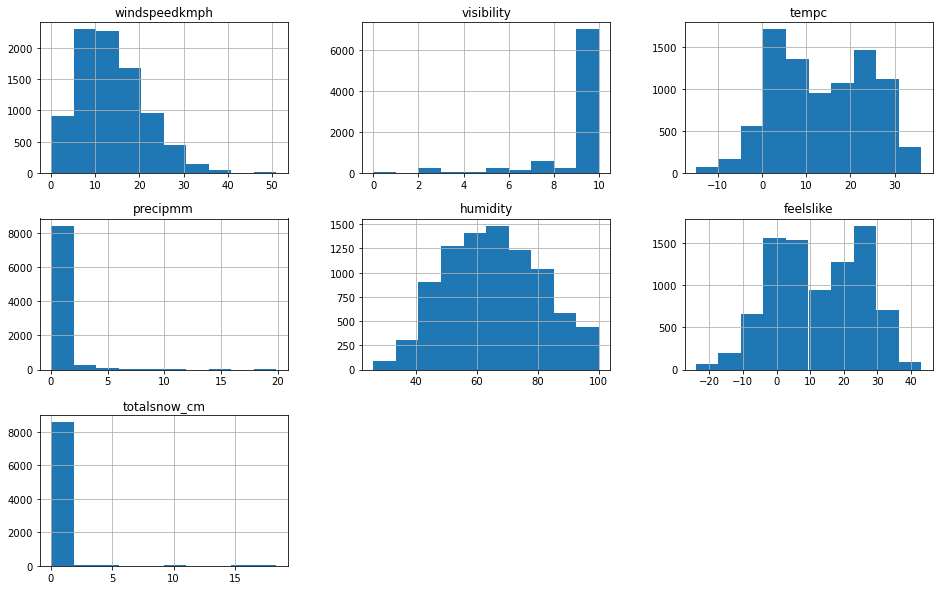

In [32]:

query = pd.read_sql_query("""
    SELECT cast(windspeedkmph as numeric (18, 2)) as windspeedkmph
    , cast(visibility as numeric (18, 2)) as visibility
    , cast(tempc as numeric (18, 2)) as tempc
    , cast(precipmm as numeric (18, 2)) as precipmm
    , cast(humidity as numeric (18, 2)) as humidity
    , cast(feelslikec as numeric (18, 2)) as feelslike
    , cast(totalSnow_cm as numeric (18, 2)) as totalSnow_cm
    FROM staging.weather_data
    Where totalsnow_cm <> 'totalSnow_cm'; """
    ,con=connect)
query.hist(figsize = (16, 10))
connect.close()

## Data Transformation & insertion to DW 

### Dimension tables

##### static dimensions - date and time

In [33]:
date_dim_calc = """
Insert Into dw.dim_date (id 
                        , day_of_week 
                        , day_of_month 
                        , week 
                        , month 
                        , quarter 
                        , year )
Select cast(date_id as date) as date_id
    , extract(isodow from date_id)-1 as day_of_week
    , extract(day from date_id) as day_of_month
    , extract(day from date_id) as week
    , extract(month from date_id) as month
    , extract(quarter from date_id) as quarter
    , extract(year from date_id) as year
From generate_series(
    '2018-01-01',
    '2020-01-01', INTERVAL '1 day'
  )as date_id  
Where
    NOT EXISTS (
        Select 1 
        From dw.dim_date as fct 
        Where fct.id = cast(date_id as date)
    )
"""

hour_dim_calc = """
Insert Into dw.dim_hour (id)
Select hour_id
From generate_series(
    0,
    23
  )as hour_id  

Where
    NOT EXISTS (
        Select 1 
        From dw.dim_hour as fct 
        Where fct.id = hour_id
    )
"""

##### slowly changing dimensions - bike stations

In [34]:
bike_station_dim_calc = """
DROP TABLE IF EXISTS stations_temp;
CREATE TEMP TABLE stations_temp AS
SELECT start_station_id as station_id
    , start_station_name as station_name
    , start_station_latitude as station_latitude
    , start_station_longitude as station_longitude
FROM staging.bike_data
Where start_station_id <> 'start_station_id'
Group By 
      start_station_id
    , start_station_name
    , start_station_latitude
    , start_station_longitude
UNION  
SELECT end_station_id
    , end_station_name
    , end_station_latitude
    , end_station_longitude
FROM staging.bike_data
Where start_station_id <> 'start_station_id'
Group By 
      end_station_id
    , end_station_name
    , end_station_latitude
    , end_station_longitude;


DROP TABLE IF EXISTS stations_temp_action;
CREATE TEMP TABLE stations_temp_action AS
Select 
      st.station_id
    , Case 
        When dw.id Is Null then 'Insert'
        When dw.id Is Not Null And Not
            (
            st.station_name = dw.name
            And Cast(st.station_latitude as  numeric(9, 6)) = dw.latitude
            And Cast(st.station_longitude as  numeric(9, 6)) = dw.longitude
            ) Then 'Update'
        End AS Action    
From stations_temp AS st
    left join 
    dw.dim_bike_station as dw
    on cast(st.station_id as int) = dw.id
    and record_end_date IS NULL; 

-- Records that need insert

Insert Into dw.dim_bike_station(id
    , record_start_date
    , record_end_date
    , name
    , longitude
    , latitude)
Select 
      cast(st.station_id as int)
    , CURRENT_TIMESTAMP
    , Null
    , st.station_name
    , cast(st.station_longitude as numeric(9, 6))
    , cast(st.station_latitude as numeric(9, 6))
From stations_temp As st
    Inner Join stations_temp_action As ac
    ON st.station_id = ac.station_id
Where 
    ac.Action = 'Insert';
    
    
 -- Records that need update:
 -- 1) close the old records
Update dw.dim_bike_station Set record_end_date =  Current_Timestamp - INTERVAL '1 DAY'
Where record_end_date IS NULL
    And id In (
        Select CAST(station_id AS int) 
        FROM stations_temp_action 
        WHERE action = 'Update');

 -- 2) add a new record with updated data
Insert Into dw.dim_bike_station(id
    , record_start_date
    , record_end_date
    , name
    , longitude
    , latitude)
Select 
      cast(st.station_id as int)
    , CURRENT_TIMESTAMP
    , Null
    , st.station_name
    , cast(st.station_longitude as numeric(9, 6))
    , cast(st.station_latitude as numeric(9, 6))
From stations_temp As st
    Inner Join stations_temp_action As ac
    ON st.station_id = ac.station_id
Where 
    ac.Action = 'Update';

"""

##### create the function for executing these procedures and then execute them.

In [35]:
%%time
def dim_calc_procedures():
    try:
        conn = create_connection()
        cur = conn.cursor()
        
        cur.execute(date_dim_calc)
        cur.execute(hour_dim_calc)
        cur.execute(bike_station_dim_calc)
        
        conn.commit()
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

dim_calc_procedures()           

Wall time: 17.7 s


##### check the populated dimension tables

In [36]:
connect = create_connection()
query_hour = pd.read_sql_query("""
    SELECT *
    FROM dw.dim_hour; """
    ,con=connect)
query_date = pd.read_sql_query("""
    SELECT *
    FROM dw.dim_date; """
    ,con=connect)
query_stations = pd.read_sql_query("""
    SELECT *
    FROM dw.dim_bike_station; """
    ,con=connect)
connect.close()

In [37]:
print(query_hour.shape) 
query_hour.head(2)

(24, 1)


,id
0,0
1,1


In [38]:
print(query_date.shape) 
query_date.head(2)

(731, 7)


,id,day_of_week,day_of_month,week,month,quarter,year
0,2018-01-01,0,1,1,1,1,2018
1,2018-01-02,1,2,2,1,1,2018


In [39]:
print(query_stations.shape) 
query_stations.head(2)

(806, 6)


,id,record_start_date,record_end_date,name,longitude,latitude
0,119,2021-08-29,None,Park Ave & St Edwards St,-73.978034,40.696089
1,120,2021-08-29,None,Lexington Ave & Classon Ave,-73.959282,40.686768


### Fact tables

##### Define the queries for populating fact tables from the staging area

In [40]:
weather_facts_calc = """
Insert Into dw.weather_facts(
      date_id 
    , hour_id 
    , totalSnow_cm 
    , FeelsLikeC 
    , humidity 
    , precipMM 
    , tempC 
    , visibility 
    , windspeedKmph 
)
    
Select cast(date_time as date) as date_id
    , cast(extract(hour from cast(date_time as timestamp)) as int) AS hour_id
    , cast(totalSnow_cm As numeric(18,4))
    , cast(FeelsLikeC As numeric(18,4))
    , cast(humidity As numeric(18,4))
    , cast(precipMM As numeric(18,4))
    , cast(tempC As numeric(18,4))
    , cast(visibility As numeric(18,4))
    , cast(windspeedKmph As numeric(18,4))
From staging.weather_data as st
Where date_time <> 'date_time'
And Not Exists (
        Select 1 
        From dw.weather_facts as fct 
        Where fct.date_id = cast(st.date_time as date)
        and fct.hour_id = cast(extract(hour from cast(date_time as timestamp)) as int)
    )    
"""


bike_facts_calc = """
Insert Into dw.bike_facts(
      date_id 
    , hour_id 
    , start_station_id 
    , end_station_id 
    , trip_distance
    , trip_duration 
    , trip_quantity
)
Select 
      cast(starttime As date) As date_id
    , cast(extract(hour from cast(starttime As timestamp)) As int) AS hour_id
    , cast(start_station_id As int) As start_station_id
    , cast(end_station_id As int) As end_station_id
    --aggregated
    , Sum(cast(trip_distance_meters as numeric(18, 4))) As trip_distance
    , Sum(cast(tripduration as numeric(18, 4))) As trip_duration
    , count(*) As trip_quantity
From staging.bike_data as b
    
Where tripduration <> 'tripduration'
Group By
      cast(starttime as date)
    , cast(extract(hour from cast(starttime as timestamp)) as int) 
    , cast(start_station_id As int)
    , cast(end_station_id As int)
"""


taxi_facts_calc = """
Insert Into dw.taxi_facts(
      date_id 
    , hour_id 
    , trip_distance 
    , trip_duration
    , trip_quantity 
    , trip_cost_total
)
Select 
      cast(pickup_datetime As date) As date_id
    , cast(extract(hour from cast(pickup_datetime As timestamp)) As int) AS hour_id
    
    --aggregated
    , Sum(cast(trip_distance as numeric(18, 4))) As trip_distance
    , Sum(
        DATE_PART(
          'second'
        , cast(dropoff_datetime as timestamp) - cast(pickup_datetime as timestamp)
        )
    ) As trip_duration
    , count(*) As trip_quantity
    , Sum(cast(total_amount as numeric(18, 4))) As trip_cost_total 
From staging.taxi_data as b
Where pickup_datetime <> 'pickup_datetime'
Group By
      cast(pickup_datetime as date)
    , cast(extract(hour from cast(pickup_datetime as timestamp)) as int)
Having Sum(
        DATE_PART(
          'second'
        , cast(dropoff_datetime as timestamp) - cast(pickup_datetime as timestamp)
        )
    ) > 0
"""


##### create a function for executing the fact table procedures and then execute them.

In [41]:
%%time
def fact_calc_procedures():
    try:
        conn = create_connection()
        cur = conn.cursor()
        
        cur.execute(weather_facts_calc)
        cur.execute(bike_facts_calc)
        cur.execute(taxi_facts_calc)
        
        conn.commit()
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()

fact_calc_procedures()           

Wall time: 1min 51s


##### check the populated fact tables

In [42]:
connect = create_connection()
query_taxi = pd.read_sql_query("""
Select * from dw.taxi_facts
""",con=connect)
query_bike = pd.read_sql_query("""
Select * from dw.bike_facts
""",con=connect)
query_weather = pd.read_sql_query("""
Select * from dw.weather_facts
""",con=connect)
connect.close()

In [43]:
print(query_taxi.shape)
query_taxi.head()

(8865, 7)


,id,date_id,hour_id,trip_distance,trip_duration,trip_quantity,trip_cost_total
0,1,2008-12-31,9,13.26,10.0,1.0,52.56
1,2,2008-12-31,11,2.97,10.0,1.0,21.80
2,3,2008-12-31,12,11.42,45.0,3.0,51.40
3,4,2008-12-31,14,29.80,15.0,2.0,110.27
4,5,2008-12-31,18,11.18,5.0,1.0,37.80


In [44]:
print(query_bike.shape)
query_bike.head()

(5027932, 8)


,id,date_id,hour_id,start_station_id,end_station_id,trip_distance,trip_duration,trip_quantity
0,1,2018-01-01,0,128,382,1269.1418,647.0,1.0
1,2,2018-01-01,0,146,249,273.6597,101.0,1.0
2,3,2018-01-01,0,161,439,771.3553,278.0,1.0
3,4,2018-01-01,0,238,461,2236.5676,1271.0,1.0
4,5,2018-01-01,0,238,494,1566.2046,399.0,1.0


In [45]:
print(query_weather.shape)
query_weather.head()

(8760, 10)


,id,date_id,hour_id,totalsnow_cm,feelslikec,humidity,precipmm,tempc,visibility,windspeedkmph
0,1,2018-01-01,0,0.0,-21.0,65.0,0.0,-12.0,10.0,23.0
1,2,2018-01-01,1,0.0,-21.0,64.0,0.0,-12.0,10.0,23.0
2,3,2018-01-01,2,0.0,-21.0,64.0,0.0,-12.0,10.0,23.0
3,4,2018-01-01,3,0.0,-21.0,64.0,0.0,-12.0,10.0,23.0
4,5,2018-01-01,4,0.0,-21.0,64.0,0.0,-12.0,10.0,22.0
